In [ ]:
from random import seed
from random import randrange
from csv import reader
from math import sqrt

# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini

# Select the best split point for a dataset
def get_split(dataset, n_features):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	features = list()
	while len(features) < n_features:
		index = randrange(len(dataset[0])-1)
		if index not in features:
			features.append(index)
	for index in features:
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}

# Create a terminal node value
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, n_features, depth):
	left, right = node['groups']
	del(node['groups'])
	# check for a no split
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# check for max depth
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left, n_features)
		split(node['left'], max_depth, min_size, n_features, depth+1)
	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right, n_features)
		split(node['right'], max_depth, min_size, n_features, depth+1)

# Build a decision tree
def build_tree(train, max_depth, min_size, n_features):
	root = get_split(train, n_features)
	split(root, max_depth, min_size, n_features, 1)
	return root

# Make a prediction with a decision tree
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']

# Create a random subsample from the dataset with replacement
def subsample(dataset, ratio):
	sample = list()
	n_sample = round(len(dataset) * ratio)
	while len(sample) < n_sample:
		index = randrange(len(dataset))
		sample.append(dataset[index])
	return sample

# Make a prediction with a list of bagged trees
def bagging_predict(trees, row):
	predictions = [predict(tree, row) for tree in trees]
	return max(set(predictions), key=predictions.count)

In [ ]:
# Random Forest Algorithm
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
	trees = list()
	for i in range(n_trees):
		sample = subsample(train, sample_size)
		tree = build_tree(sample, max_depth, min_size, n_features)
		trees.append(tree)
	predictions = [bagging_predict(trees, row) for row in test]
	return(predictions)

# Test the random forest algorithm
seed(2)
# load and prepare data
filename = 'sonar.all-data.csv'
dataset = load_csv(filename)
# convert string attributes to integers
for i in range(0, len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# evaluate algorithm
n_folds = 5
max_depth = 10
min_size = 1
sample_size = 1.0
n_features = int(sqrt(len(dataset[0])-1))
for n_trees in [1, 5, 10]:
	scores = evaluate_algorithm(dataset, random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
	print('Trees: %d' % n_trees)
	print('Scores: %s' % scores)
	print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('Bank.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


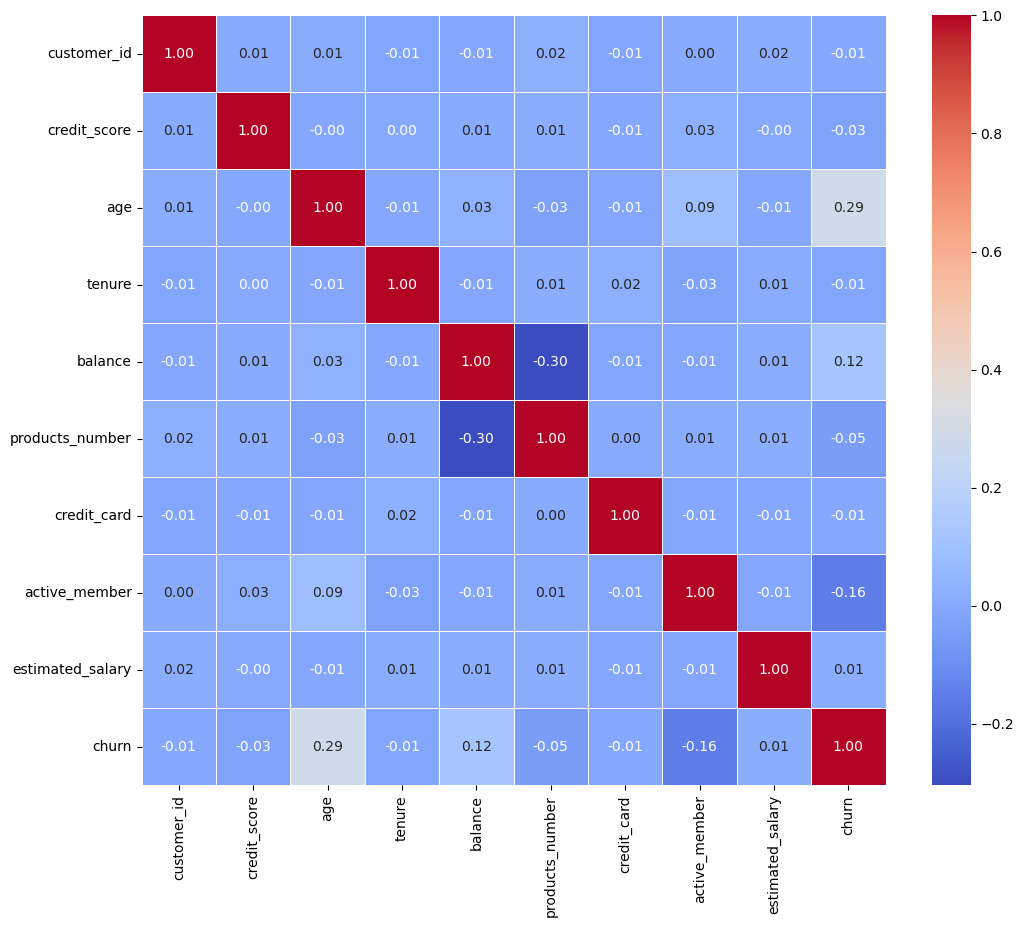

In [35]:
# # Replace non-numeric values with NaN
# data = data.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
# # Filter only numerical columns
# numeric_cols = data.select_dtypes(include=[np.number])

data["country"] = np.nan
data["gender"] = np.nan
# Calculate correlation
df_numeric = data.drop(['gender', 'country'], axis=1)

# Generate a correlation matrix
correlation_matrix = df_numeric.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Show the plot
plt.show()


In [16]:
data["country"] = np.nan
data["gender"] = np.nan